In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re

import read_nml as rnl

from Utils import numerical_utils as nuti
from Utils import constants as Co

print( Co.cpair())

cpair = Co.cpair()
grav= Co.grav()

1004.6480897776704


In [3]:

#################
# set case name
#################
#case='camsnap-Baseline01'
case='xy-Baseline01'
case='xy-test03'
year,month=2004,6

f=f'/glade/derecho/scratch/juliob/archive/GW_UnitTest/{case}/{case}.h.{year:04}-{month:02}-*.nc'     #        camsnap-yaaaa.h.2004-06-15-21600.nc'
title=f'{case}: {year:04}-{month:02}'     #        camsnap-yaaaa.h.2004-06-15-21600.nc'

Xgw=xr.open_mfdataset( f   ,data_vars='different', coords='different' )

ncdata=Xgw.ncdata
X=xr.open_dataset( ncdata )

print(ncdata)


/glade/derecho/scratch/juliob/archive/ndg_x02_ne30pg3_fmt_c64109/atm/hist/ndg_x02_ne30pg3_fmt_c64109.cam.h2i.2004-06-15-00000.nc


In [ ]:
print(Xgw.time.values)

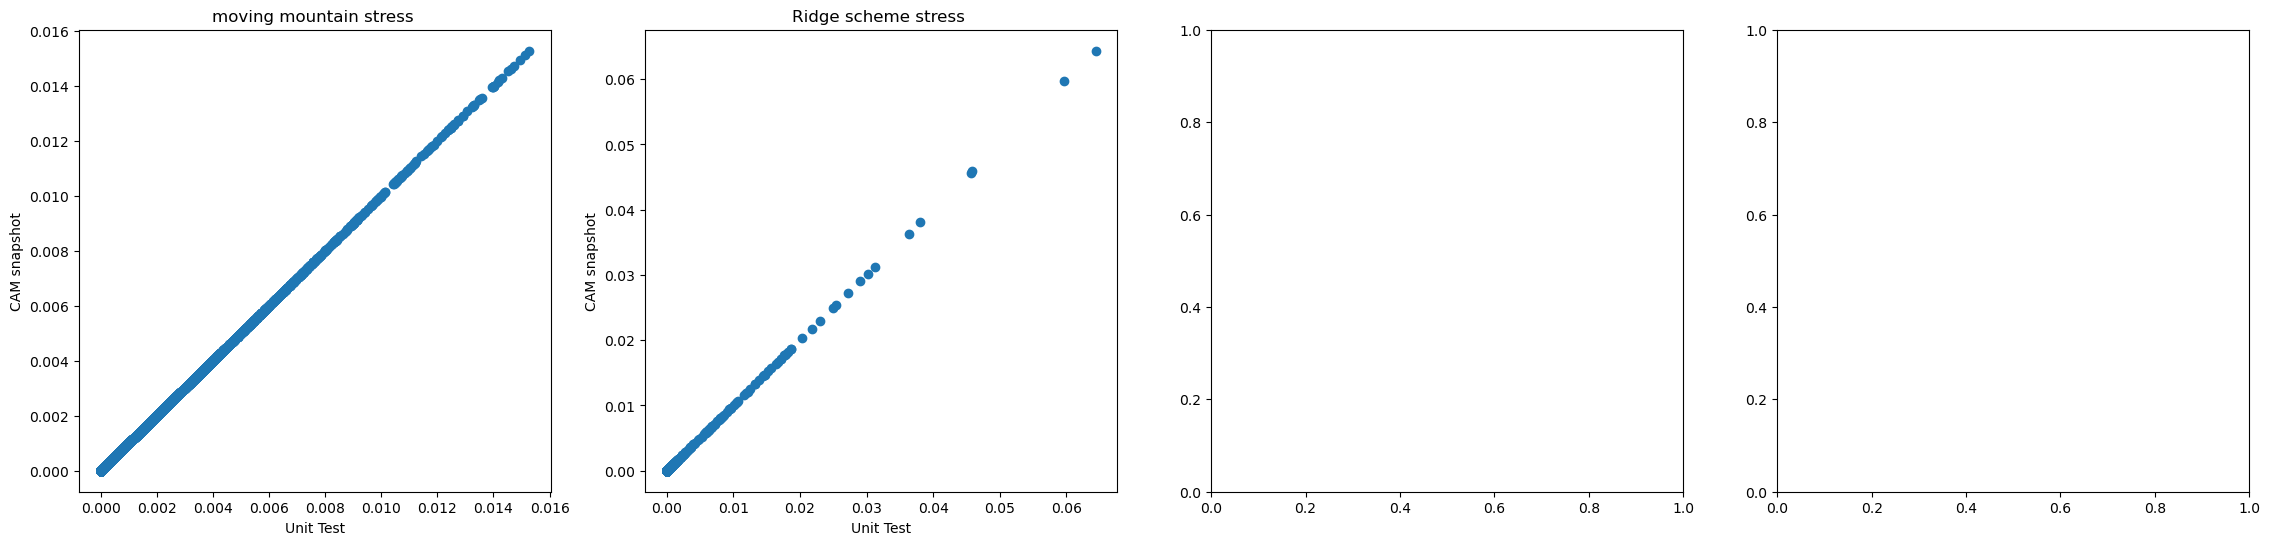

In [4]:
#read GW.dat file

%run -i val_camsnap_block.py


In [ ]:
ncdata=Xgw.ncdata

In [ ]:
print( ncdata )

In [ ]:


#s = "/glade/derecho/scratch/juliob/archive//c153_topfix_ne240pg3_FMTHIST_xic_x02/atm/fv1x1/c153_topfix_ne240pg3_FMTHIST_xic_x02.cam.h1i.2004-07-01-00000.nc"

# Replace date tag of the form YYYY-MM-DD-##### with '*'
#ncdata_star = re.sub(r'\d{4}-\d{2}-\d{2}-\d{5}', '*', ncdata)
ncdata_star = re.sub(r'\d{2}-\d{5}', '*', ncdata)

print(ncdata_star)


In [ ]:
X=xr.open_mfdataset( ncdata_star   ,data_vars='different', coords='different' )

In [ ]:
X

In [ ]:
Xgw

In [ ]:
%%time

tau_rdg=Xgw.TAU_RDG.values
tau_mmt=Xgw.TAU_MOVMTN.values

upwp = X.upwp.values
vpwp = X.vpwp.values


In [ ]:
epwp = np.sqrt( upwp**2 + vpwp**2 )


In [ ]:

print( Xgw.sizes )#[('ny','nx')])
nt,nz,ny,nx = Xgw.sizes['time'],  Xgw.sizes['level'],  Xgw.sizes['ny'],  Xgw.sizes['nx']

In [ ]:
%%time
tau_rdg = tau_rdg.reshape((nt,nz+1,ny,nx) )
tau_mmt = tau_mmt.reshape((nt,nz+1,ny,nx) )

tau_tot = tau_rdg + tau_mmt

In [ ]:
tau_rdg_tv = np.average( tau_rdg, axis=0)
tau_mmt_tv = np.average( tau_mmt, axis=0)
tau_tot_tv = np.average( tau_tot, axis=0)

upwp_tv = np.average(upwp,axis=0)
epwp_tv = np.average(epwp,axis=0)


In [ ]:
from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors

# A: 2D array (ny, nx)
#A_smooth = uniform_filter(A, size=3, mode="nearest")   # 3x3
# A_smooth = uniform_filter(A, size=5, mode="nearest") # 5x5


In [ ]:
z=40
tau_tot_smooth = uniform_filter(   tau_tot_tv[z,:,:]  , size=7, mode="wrap")   # 3x3

trunc_k, sigma=7, 1.5
tau_smooth = gaussian_filter(  tau_tot_tv[z,:,:] , sigma=sigma,
                           truncate=((trunc_k-1)/2)/sigma, mode="nearest")


flev=[0.0001,0.0002,0.0005,  0.001,0.002,0.005,  0.01,0.02,0.05,  0.1,0.2,0.5,   1.0  ]
print(flev)
cmap='gist_ncar'

cmap = plt.cm.bwr  #gist_ncar  # Or any other colormap
norm = mcolors.BoundaryNorm(boundaries=flev, ncolors=cmap.N, clip=False)




fig,axs=plt.subplots( 1, 3, figsize=(30,6) )
ax=axs[0]
c = ax.contourf( tau_tot_tv[z,:,:],levels=flev, cmap=cmap , norm=norm, extend='both'  )
plt.colorbar( c )

ax=axs[1]
c = ax.contourf( tau_tot_smooth,levels=flev, cmap=cmap , norm=norm, extend='both'  )
ax.set_title( " Smoothed param GW "+ r"$\tau$")
plt.colorbar( c )


ax=axs[2]
c = ax.contourf( epwp_tv[z,:,:],levels=flev, cmap=cmap , norm=norm, extend='both'  )
plt.colorbar( c )

plt.suptitle( title , fontsize=24)


In [ ]:
print(X.lev[z].values)